# 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

In [2]:
%%capture
%pip install git+https://github.com/probml/rebayes.git
%pip install augmax
%pip install distrax
%pip install jaxtyping
%pip install jax-tqdm
%pip install bayesian-optimization
%pip install jax-dataloader
%pip install blackjax

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_swiss_roll


import jax
import jax.numpy as jnp

try:
    from flax import linen as nn  # The Linen API
except ModuleNotFoundError:
    %pip install -qq flax
    from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

try:
    import optax  # Optimizers
except ModuleNotFoundError:
    %pip install -qq optax
    import optax  # Optimizers

from functools import partial

from IPython.display import clear_output

In [4]:
from typing import Callable, Sequence

import jax.random as jr
import jax_dataloader.core as jdl

from rebayes.low_rank_filter.lofi import RebayesGradientLoFi, RebayesLoFiDiagonal

In [5]:
from functools import partial

from bayes_opt import BayesianOptimization
import jax.numpy as jnp
import jax.random as jr
from jax.flatten_util import ravel_pytree
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from jax import vmap
import jax
from matplotlib import animation

from rebayes.extended_kalman_filter.ekf import RebayesNFEKF
from rebayes.extended_kalman_filter.ekf import RebayesEKF
import rebayes.utils.callbacks as callbacks
import rebayes.utils.models as models
from rebayes.utils.normalizing_flows import NF_MLP, init_normalizing_flow, construct_flow

tfd = tfp.distributions
MVN = tfd.MultivariateNormalTriL
MVD = tfd.MultivariateNormalDiag

# 1. Swiss Roll

## 1.1. Data

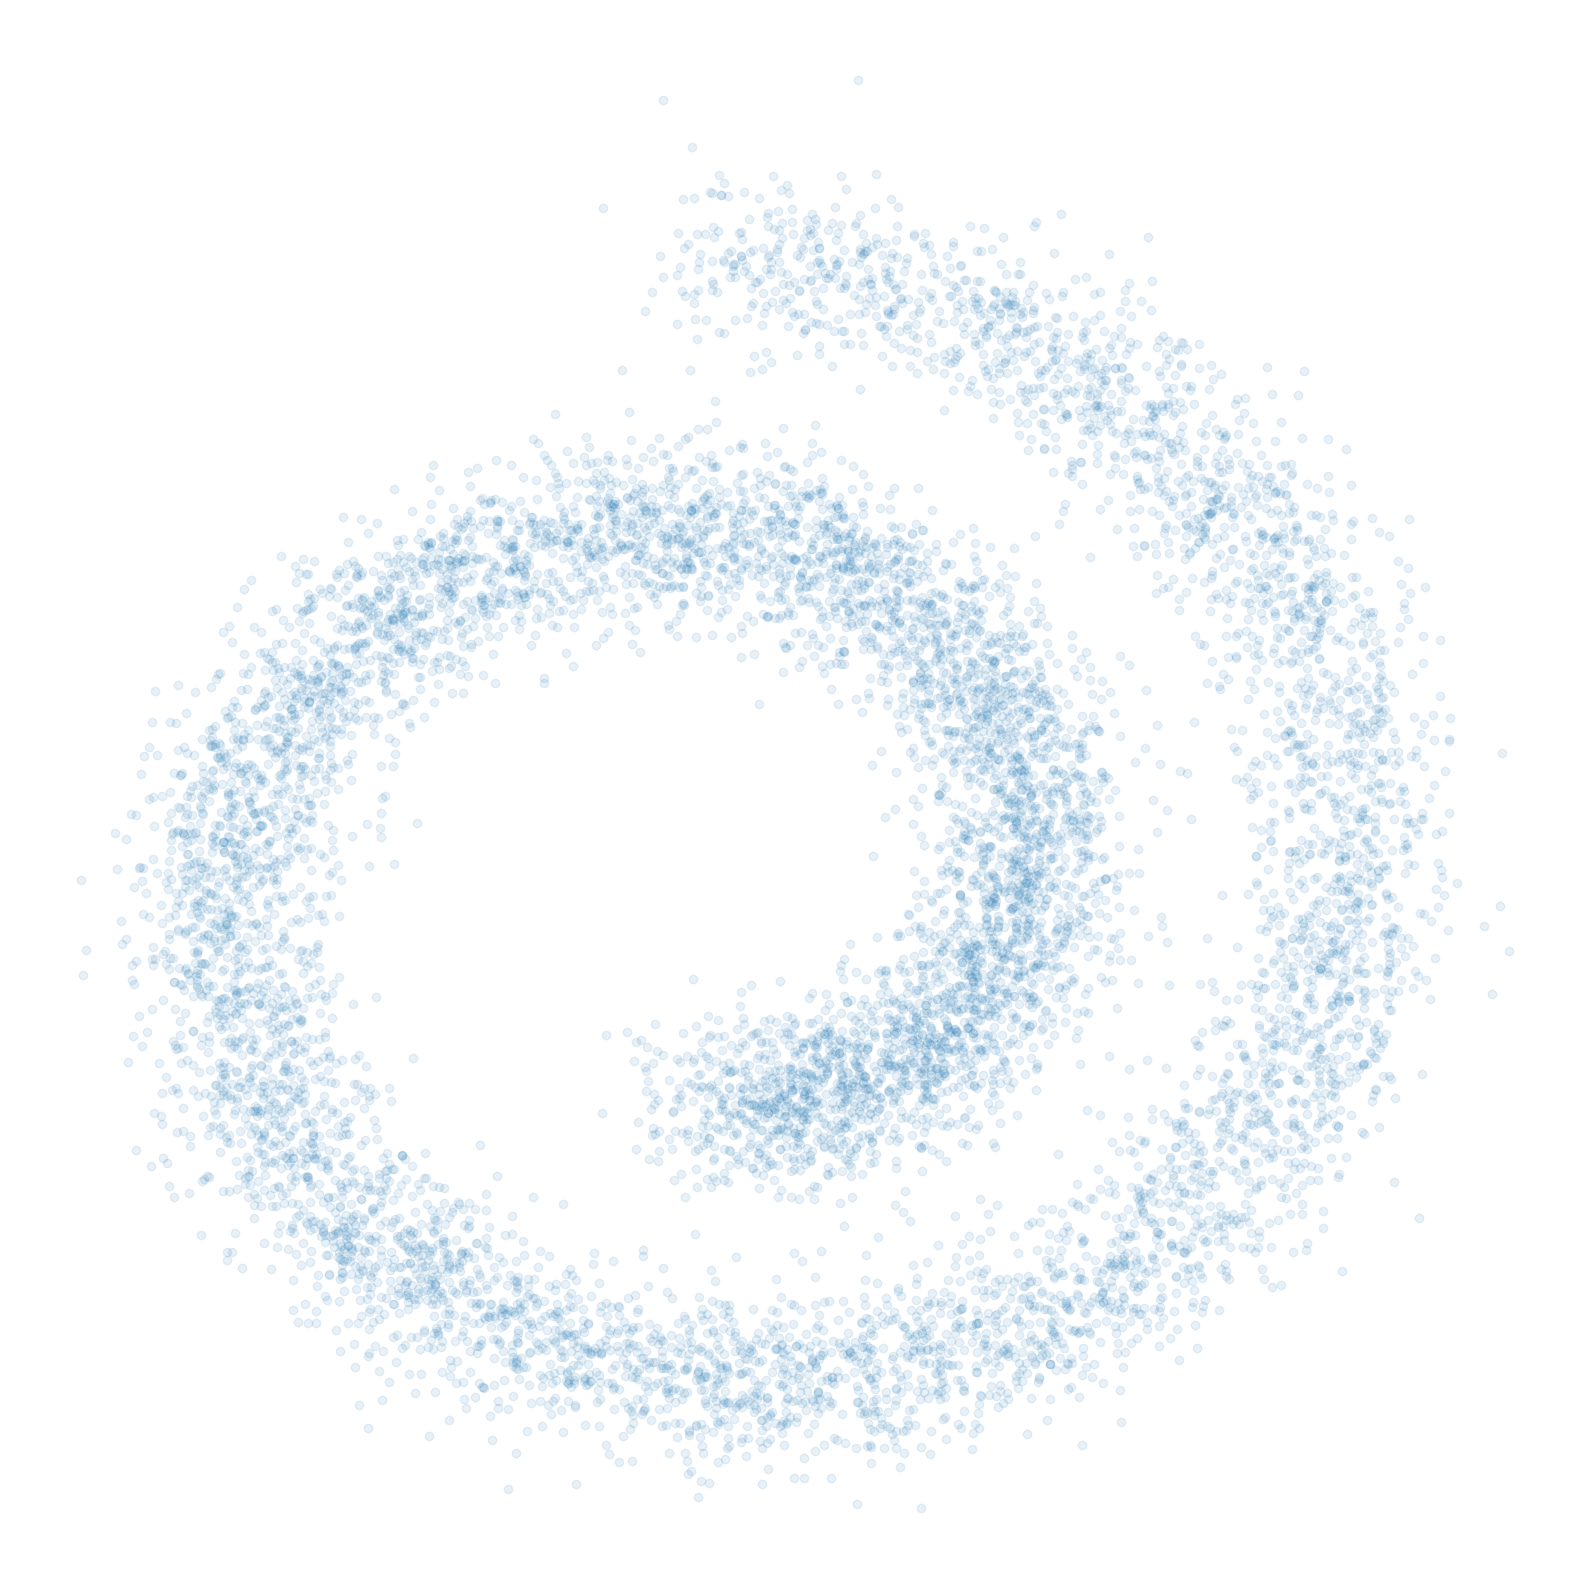

In [ ]:
def sample_batch(size, noise=1.0):
    x, _ = make_swiss_roll(size, noise=noise)
    x = x[:, [0, 2]] / 10.0

    return jnp.array(x)

plt.figure(figsize=[16, 16])
plt.scatter(*sample_batch(10**4).T, alpha=0.1)
plt.axis("off")
plt.tight_layout()
plt.savefig("swiss_roll.png")

In [ ]:
class MLP(nn.Module):
    features: Sequence[int]
    activation: nn.Module = nn.softplus

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = self.activation(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)

        return x

In [ ]:
@partial(jax.jit, static_argnames=("applyfn",))
def loss_fn(params, X, y, applyfn):
    jacobian = jax.jacfwd(applyfn, argnums=-1)
    trace_jacobian = jnp.trace(jacobian(params, X))
    output_norm_sq = jnp.square(applyfn(params, X)).sum()

    return jnp.mean(trace_jacobian + 1 / 2 * output_norm_sq)

In [ ]:
# Set up MLP
obs_var=0.01
model = MLP([128, 128, 2,])
params = model.init(
    jr.PRNGKey(0), jnp.ones(2,)
)
flat_params, unflatten_fn = ravel_pytree(params)
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))
apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)
emission_mean_function = apply_fn
emission_cov_function =lambda w, x: obs_var * jnp.eye(1)

In [ ]:
def callback_fn(bel, pred_obs, t, x, y, bel_pred, **kwargs):
    agent = kwargs["agent"]
    test_set = kwargs["test_set"]
    grid = kwargs["grid"]
    losses = jax.vmap(
        agent.loss_fn, (None, 0, None)
    )(bel.mean, test_set, y)
    loss = losses.mean()
    scores = jax.vmap(
        agent.emission_mean_function, (None, 0)
    )(bel.mean, grid)

    return loss, scores

## 1.2. Gradient LoFi (Batch Size 1)

In [ ]:
agent = RebayesGradientLoFi(
    dynamics_weights=1.0,
    dynamics_covariance=0.0,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    loss_fn=loss_fn,
    correction_method="momentum-correction",
    momentum_weight=0.0,
)

In [74]:
train_set = sample_batch(256_000)
test_set = sample_batch(1000)
xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 2.0, 50), jnp.linspace(-1.5, 2.0, 50)), axis=-1
).reshape(-1, 2)

agent_kwargs = {
    "agent": agent,
    "test_set": test_set,
    "grid": xx,
}

initial_covariance=0.2

bel_final, outputs = agent.scan(
    flat_params, initial_covariance, train_set, train_set, callback=callback_fn,
    **agent_kwargs
)

In [75]:
losses, scores_history = outputs
scores = scores_history[-1]

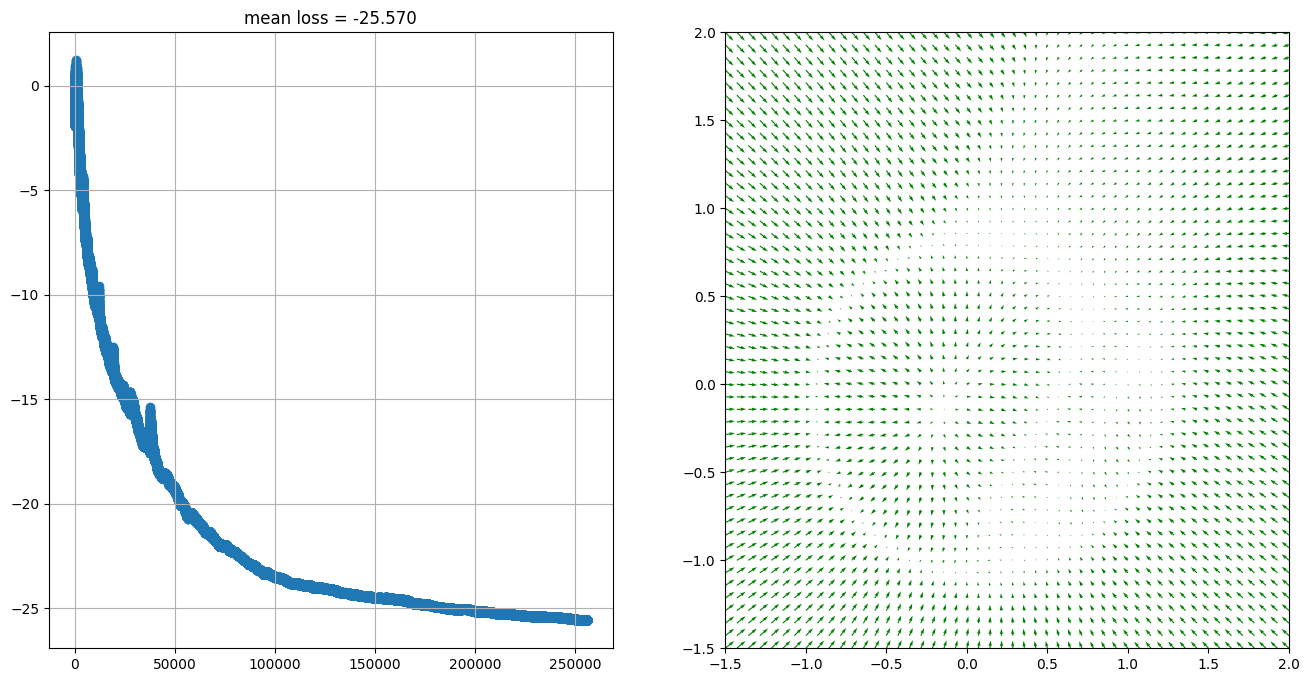

In [76]:
plt.figure(figsize=[16, 8])

plt.subplot(1, 2, 1)
plt.title("mean loss = %.3f" % jnp.mean(jnp.array(losses[-32:])))
plt.scatter(jnp.arange(len(losses)), losses)
plt.grid()

plt.subplot(1, 2, 2)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.xlim(-1.5, 2.0)
plt.ylim(-1.5, 2.0)
plt.show()

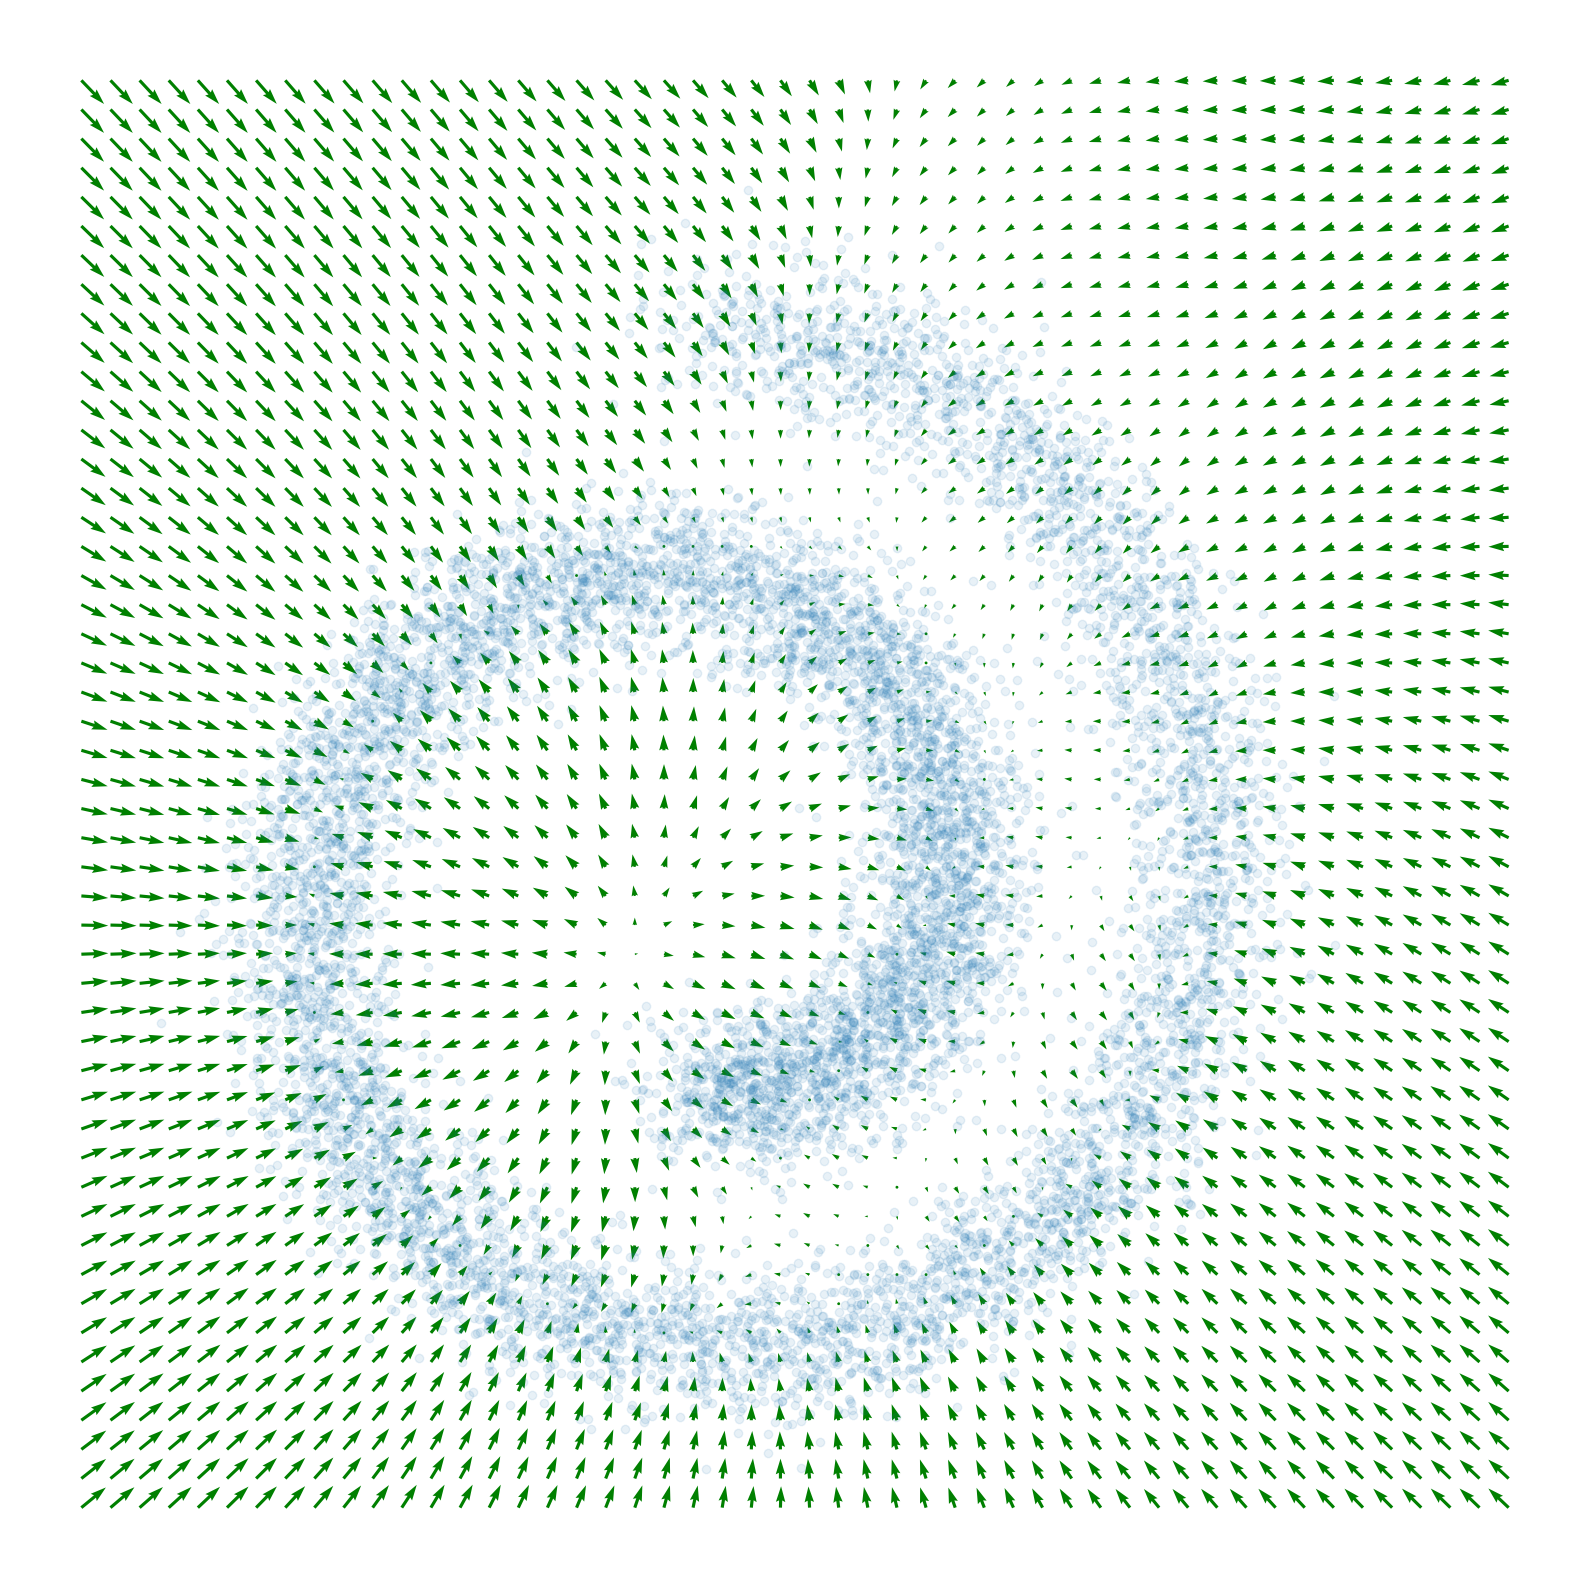

In [77]:
plt.figure(figsize=[16, 16])
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.axis("off")
plt.tight_layout()
plt.savefig("score_matching_swiss_roll.png")

In [ ]:
scores0 = scores_history[0]
scores_norm0 = jnp.linalg.norm(scores0, axis=-1, ord=2, keepdims=True)
scores_log1p0 = scores0 / (scores_norm0 + 1e-9) * jnp.log1p(scores_norm0)

In [49]:
# %matplotlib inline

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # create a figure and axes
# fig, ax = plt.subplots(figsize=(8, 8))
# title = ax.set_title('Posterior Gradient Field: Step 0')
# ax.set_xlim(-1.5, 2.0)
# ax.set_ylim(-1.5, 2.0)

# # create objects that will change in the animation. These are
# # initially empty, and will be given new values for each frame
# # in the animation.
# line = ax.quiver(*xx.T, *scores_log1p0.T, width=0.002, color="green")

In [ ]:
def drawframe(n, line, title):
    scores = scores_history[200*n]
    scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)
    line.set_UVC(*scores_log1p.T)
    title.set_text(f'Posterior Gradient Field: Step {200*n+1}')

    return line, title

In [ ]:
anim = animation.FuncAnimation(
    fig, drawframe, frames=len(scores_history)//200,
    interval=40, blit=True, fargs=(line, title)
)

In [48]:
# from IPython.display import HTML
# HTML(anim.to_html5_video())

## 1.3. Gradient LoFi (Batch Size 128)

In [54]:
agent = RebayesGradientLoFi(
    dynamics_weights=1.0,
    dynamics_covariance=0.0,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    loss_fn=loss_fn,
    correction_method="momentum-correction",
    momentum_weight=0.0,
)

In [55]:
def batch_callback_fn(i, bel_pre_updated, bel, batch, **kwargs):
    agent = kwargs["agent"]
    test_set = kwargs["test_set"]
    grid = kwargs["grid"]
    losses = jax.vmap(
        agent.loss_fn, (None, 0, 0)
    )(bel.mean, test_set, test_set)
    loss = losses.mean()
    scores = jax.vmap(
        agent.emission_mean_function, (None, 0)
    )(bel.mean, grid)

    return loss, scores

In [56]:
n_train = 10_000 * 128
Xtr, Ytr = sample_batch(n_train), sample_batch(n_train)
Xte, Yte = sample_batch(1000), sample_batch(1000)

train_ds = jdl.ArrayDataset(Xtr, Ytr)
train_loader = jdl.DataLoaderJax(
    train_ds, batch_size=128, shuffle=False, drop_last=False
)


xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 2.0, 50), jnp.linspace(-1.5, 2.0, 50)), axis=-1
).reshape(-1, 2)

agent_kwargs = {
    "agent": agent,
    "test_set": Xte,
    "grid": xx,
}

initial_covariance=0.5

bel_final, outputs = agent.scan_dataloader(
    flat_params, initial_covariance, train_loader, callback=batch_callback_fn,
    **agent_kwargs
)

In [57]:
losses, scores_history = [], []
for output in outputs:
    losses.append(output[0])
    scores_history.append(output[1])

scores = scores_history[-1]

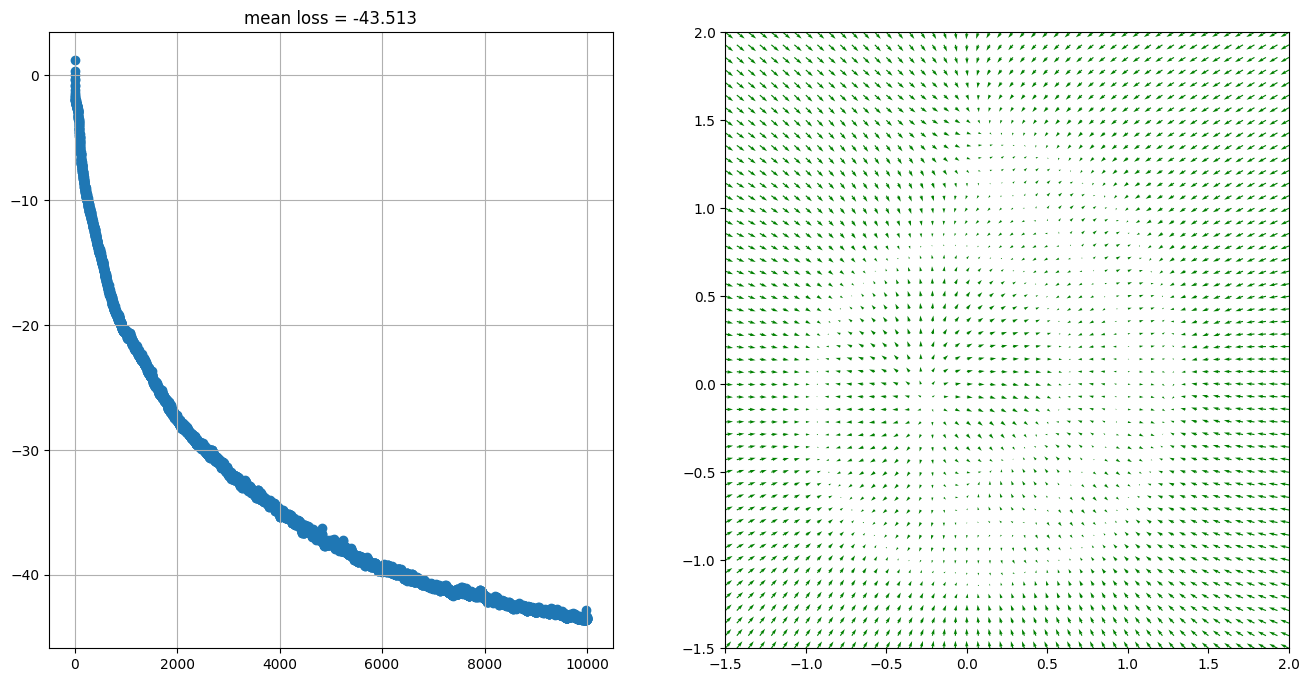

In [58]:
plt.figure(figsize=[16, 8])

plt.subplot(1, 2, 1)
plt.title("mean loss = %.3f" % jnp.mean(jnp.array(losses[-32:])))
plt.scatter(jnp.arange(len(losses)), losses)
plt.grid()

plt.subplot(1, 2, 2)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.xlim(-1.5, 2.0)
plt.ylim(-1.5, 2.0)
plt.show()

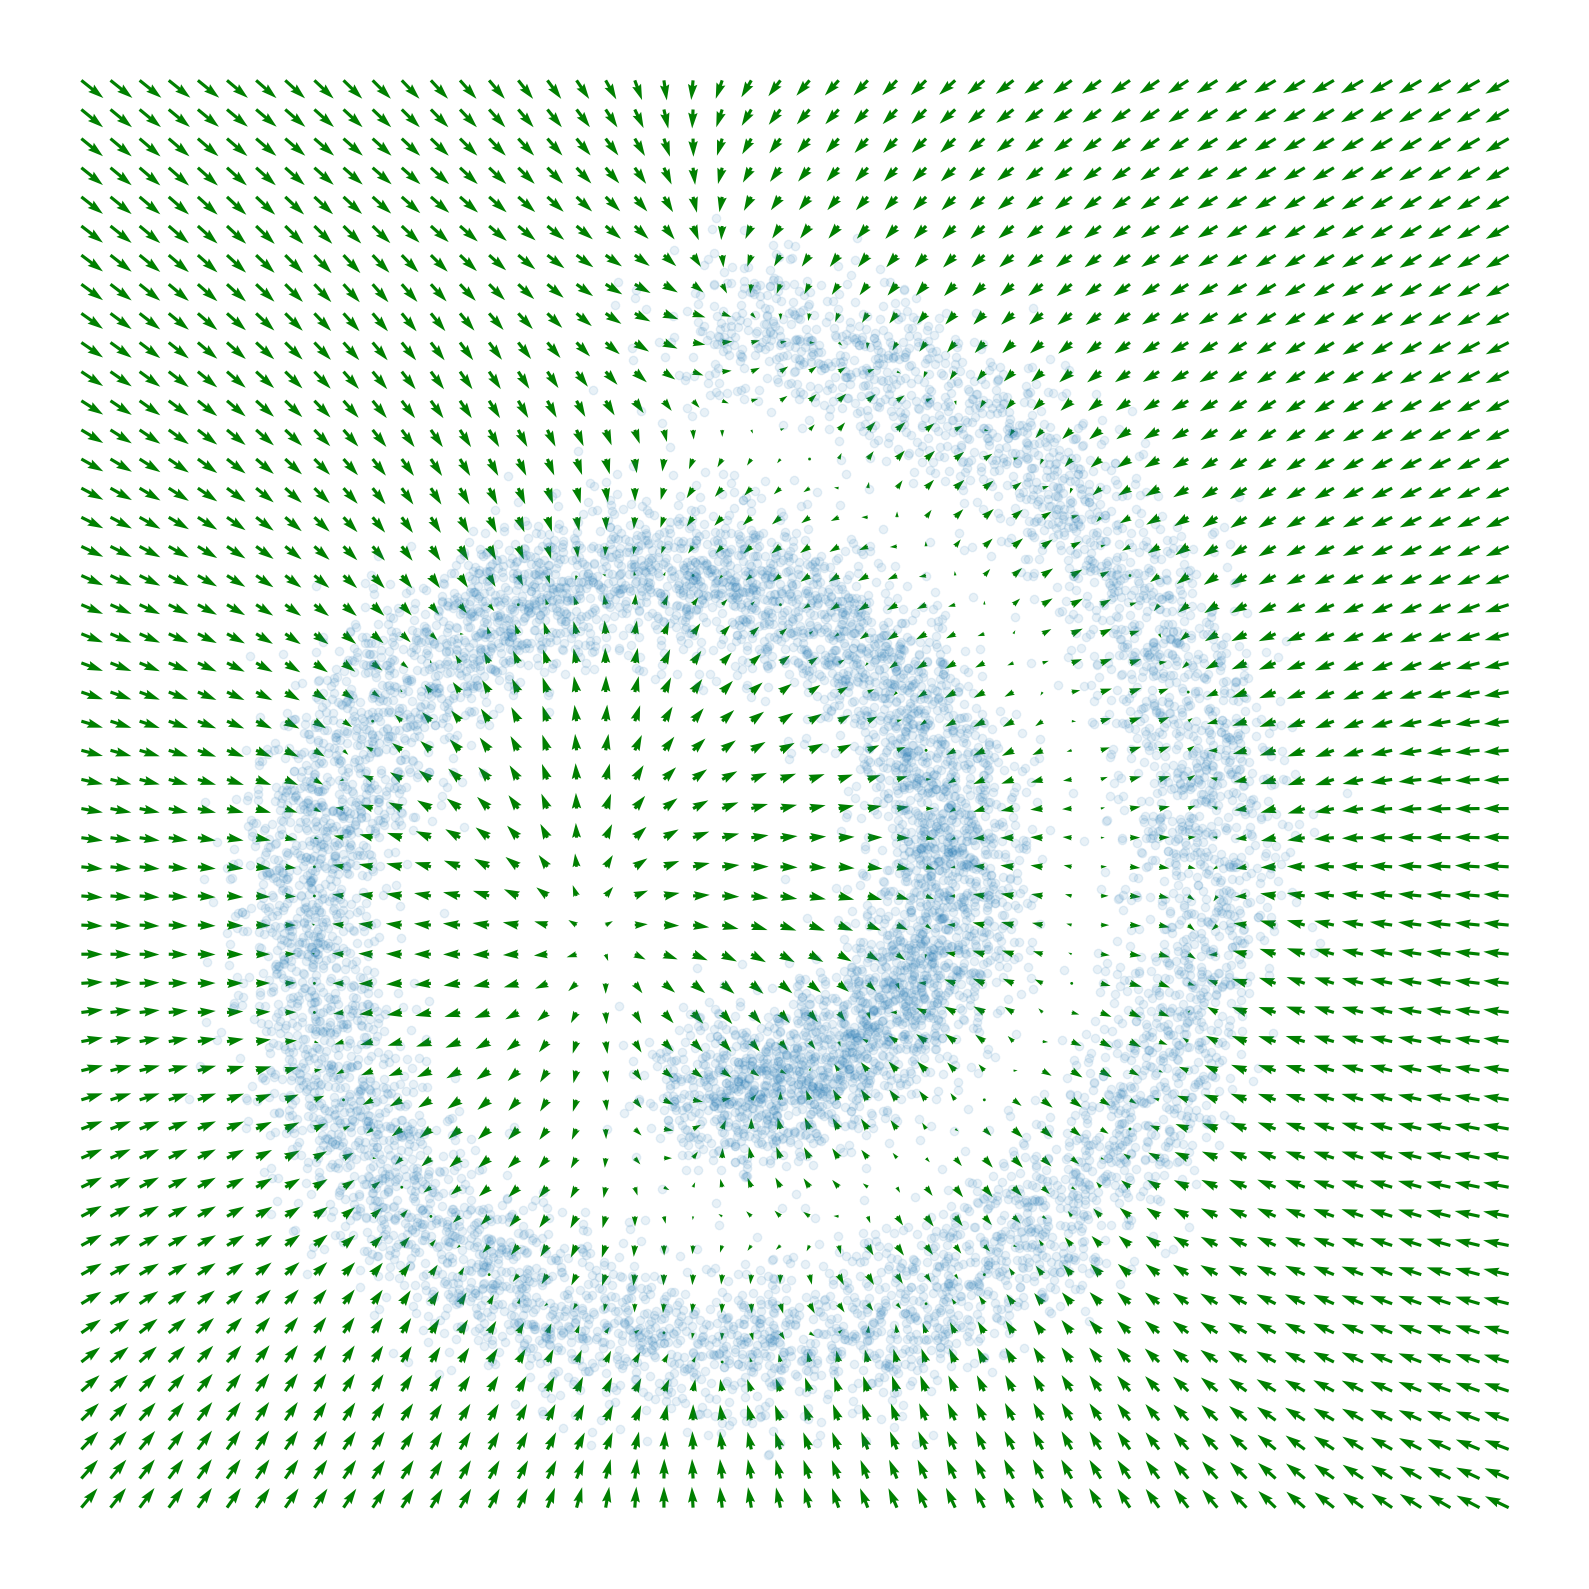

In [59]:
plt.figure(figsize=[16, 16])
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.axis("off")
plt.tight_layout()
plt.savefig("score_matching_swiss_roll.png")

In [62]:
import blackjax

In [64]:
log_density_fn = lambda x: apply_fn(bel_final.mean, x)

inv_mass_matrix = jnp.ones(2,)
num_integration_steps = 100
step_size = 1e-3

In [69]:
log_density_fn(initial_position)

Array([23.389866 ,  1.4905239], dtype=float32)

In [66]:
nuts_kernel = blackjax.nuts(log_density_fn, step_size, inv_mass_matrix)

# 2. MNIST